In [103]:
# not going to use as its unreliable, however it could suggested as a future improvement
import cv2
import math
import pandas as pd
import numpy as np
import imutils
import imageio as imio # Reading images
from skimage import data # Image operations
from skimage.color import rgb2gray # RGB image to grey
from matplotlib import pyplot as plt
from skimage.transform import resize # Resize images

In [112]:
def load_image(path):
    return np.array(imio.imread(path))

def perspective_transform(image, corners):
    def order_corner_points(corners):
        # Separate corners into individual points
        # Index 0 - top-right
        #       1 - top-left
        #       2 - bottom-left
        #       3 - bottom-right
        corners = [(corner[0][0], corner[0][1]) for corner in corners]
        top_r, top_l, bottom_l, bottom_r = corners[0], corners[1], corners[2], corners[3]
        return (top_l, top_r, bottom_r, bottom_l)

    # Order points in clockwise order
    ordered_corners = order_corner_points(corners)
    top_l, top_r, bottom_r, bottom_l = ordered_corners

    # Determine width of new image which is the max distance between 
    # (bottom right and bottom left) or (top right and top left) x-coordinates
    width_A = np.sqrt(((bottom_r[0] - bottom_l[0]) ** 2) + ((bottom_r[1] - bottom_l[1]) ** 2))
    width_B = np.sqrt(((top_r[0] - top_l[0]) ** 2) + ((top_r[1] - top_l[1]) ** 2))
    width = max(int(width_A), int(width_B))

    # Determine height of new image which is the max distance between 
    # (top right and bottom right) or (top left and bottom left) y-coordinates
    height_A = np.sqrt(((top_r[0] - bottom_r[0]) ** 2) + ((top_r[1] - bottom_r[1]) ** 2))
    height_B = np.sqrt(((top_l[0] - bottom_l[0]) ** 2) + ((top_l[1] - bottom_l[1]) ** 2))
    height = max(int(height_A), int(height_B))

    # Construct new points to obtain top-down view of image in 
    # top_r, top_l, bottom_l, bottom_r order
    dimensions = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], 
                    [0, height - 1]], dtype = "float32")

    # Convert to Numpy format
    ordered_corners = np.array(ordered_corners, dtype="float32")

    # Find perspective transform matrix
    matrix = cv2.getPerspectiveTransform(ordered_corners, dimensions)

    # Return the transformed image
    return cv2.warpPerspective(image, matrix, (width, height))

def alignTrey(input, inputIsFile = False ,returnOutput = True, saveOutput = False, filePath=''):
    image = None
    # Load the image
    if (inputIsFile):
        image = load_image(input)
    else:
        image = input
    
    # keep a copy of the initial file
    original = image.copy()
    
    # convert the image to greyscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # create a binary mask
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    # dilate the edges in the image
    s = int(int(math.ceil(image.shape[0]/2 / 1000.0) * 1000)/10)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(s,s))
    dilated = cv2.dilate(thresh, kernel)
    
    # Find the contours
    cnts = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    c_area = 0 # Keeps track of the largest contour thats been processed
    transformed = None
    for c in cnts:
        # Calculate the ark length
        peri = cv2.arcLength(c, True)
        # approximate the ark
        approx = cv2.approxPolyDP(c, 0.015 * peri, True)
        
        # if the contour has 4 edges...
        if len(approx) == 4:
            n_c_area = cv2.contourArea(c)
            print(n_c_area)
            # and the area is the largest processed so far
            if (n_c_area > c_area):                
                c_area = n_c_area
                # Perspective transform for top-down view
                transformed = perspective_transform(original, approx)
    final = original
    
    # Rotate image to get correct orientation and convert it to RGB
    if(transformed.shape[0]>transformed.shape[1]):
        final = imutils.rotate_bound(transformed, angle=-90)
    else:
        final = transformed
        
        
    if (saveOutput):
        imio.imwrite(filePath,final)
        
    if (returnOutput):
        return final
    
def alignTrey1(input, inputIsFile = False ,returnOutput = True, saveOutput = False, filePath=''):
    image = None
    # Load the image
    if (inputIsFile):
        image = load_image(input)
    else:
        image = input
    
    # keep a copy of the initial file
    original = image.copy()
    
    # convert the image to greyscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # create a binary mask
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
      
    # Find the contours
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x,y,w,h = cv2.boundingRect(cnts[0])
    final = original[y:h,x:w]
        
    if (saveOutput):
        imio.imwrite(filePath,final)
        
    if (returnOutput):
        return final

5701073.5


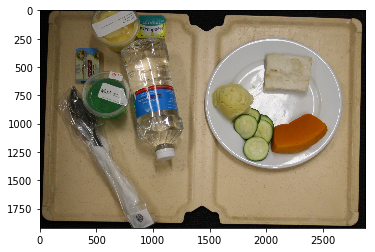

In [105]:
plt.imshow(alignTrey('2.JPG',True,True,False))

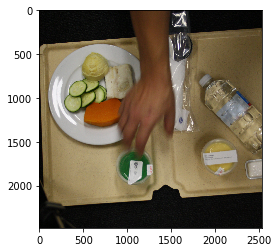

In [113]:
plt.imshow(alignTrey1('1.JPG',True,True,False))